In [1]:
import pandas as pd

data = pd.read_csv('data/student_info_cleaned.csv')
data.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,score,grade,studied_credits_binned
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,82.4,A-,201+
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,65.4,C,30-60
2,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,76.3,B,30-60
3,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,55.0,D,30-60
4,AAA,2013J,38053,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass,66.9,C,30-60


In [ ]:
data.info()

In [2]:
data['final_result'].value_counts()
#drop withdrawn students
data = data[data['final_result'] != 'Withdrawn']

In [3]:
import numpy as np
#order highest_education, imd_band, age_band, disability, studied_credits_binned, final_result
highest_education = {
    'No Formal quals': 0,
    'Lower Than A Level': 1,
    'A Level or Equivalent': 2,
    'HE Qualification': 3,
    'Post Graduate Qualification': 4
}

imd_band = {
    np.nan: -1,
    '0-10%': 0,
    '10-20': 1,
    '20-30%': 2,
    '30-40%': 3,
    '40-50%': 4,
    '50-60%': 5,
    '60-70%': 6,
    '70-80%': 7,
    '80-90%': 8,
    '90-100%': 9
}

age_band = {
    '0-35': 0,
    '35-55': 1,
    '55<=': 2
}

disability = {
    'N': 0,
    'Y': 1
}

studied_credits_binned = {
    '30-60': 0,
    '61-100': 1,
    '101-200': 2,
    '201+': 3
}

final_result = {
    'Fail': 0,
    'Pass': 1,
    'Distinction': 1,
    'Withdrawn': 0
}

data_dummies = pd.get_dummies(data, columns=['code_module', 'code_presentation', 'gender', 'region'])
data_dummies['highest_education'] = data_dummies['highest_education'].map(highest_education)
data_dummies['imd_band'] = data_dummies['imd_band'].map(imd_band)
data_dummies['age_band'] = data_dummies['age_band'].map(age_band)
data_dummies['disability'] = data_dummies['disability'].map(disability)
data_dummies['studied_credits_binned'] = data_dummies['studied_credits_binned'].map(studied_credits_binned)
data_dummies['final_result'] = data_dummies['final_result'].map(final_result)

# from sklearn.preprocessing import LabelEncoder
# data_ordinal = data.copy()
# data_ordinal['highest_education'] = data_dummies['highest_education']
# data_ordinal['imd_band'] = data_dummies['imd_band']
# data_ordinal['age_band'] = data_dummies['age_band']
# data_ordinal['disability'] = data_dummies['disability']
# data_ordinal['studied_credits_binned'] = data_dummies['studied_credits_binned']
# data_ordinal['final_result'] = data_dummies['final_result']

# le = LabelEncoder()
# data_ordinal['code_module'] = le.fit_transform(data_ordinal['code_module'])
# data_ordinal['code_presentation'] = le.fit_transform(data_ordinal['code_presentation'])
# data_ordinal['gender'] = le.fit_transform(data_ordinal['gender'])
# data_ordinal['region'] = le.fit_transform(data_ordinal['region'])


In [21]:
data_dummies['score'].value_counts()

70.000000    55
66.000000    52
60.000000    52
80.000000    50
56.000000    49
             ..
63.890000     1
55.262626     1
52.204082     1
54.185930     1
54.989637     1
Name: score, Length: 11668, dtype: int64

model building

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE#pip install imbalanced-learn



X_dummy = data_dummies.drop(['final_result', 'studied_credits', 'id_student', 'score', 'grade'], axis=1)
X_dummy_combined = X_dummy.copy()
X_dummy_combined['score'] = data_dummies['score']
# X_dummy_combined.loc[(X_dummy_combined['score'] < 50) & (y_dummy['final_result'] == 1), 'score'] = 76
# X_dummy_combined.loc[y_dummy['final_result'] == 0, 'score'] = 35


y_dummy = data_dummies[['final_result']]

smote = SMOTE(sampling_strategy='minority', random_state=42)
X_dummy_smote, y_dummy_smote = smote.fit_resample(X_dummy_combined, y_dummy)

y_dummy_smote['score'] = X_dummy_smote['score']
y_dummy['score'] = X_dummy_combined['score']
X_dummy_smote = X_dummy_smote.drop(['score'], axis=1)

/tmp/ipykernel_40831/2502644455.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_dummy['score'] = X_dummy_combined['score']


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_dummy_smote = pd.read_csv('data/X_dummy_smote.csv')
y_dummy_smote = pd.read_csv('data/y_dummy_smote.csv')
X_ord_smote = pd.read_csv('data/X_ord_smote.csv')
y_ord_smote = pd.read_csv('data/y_ord_smote.csv')

/var/folders/1z/_j8y7ndj06788g4f84n47dqm0000gn/T/ipykernel_18029/3644116101.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [28]:
print(X_dummy_smote.shape)
print(y_dummy_smote.shape)

(27736, 31)
(27736, 2)


In [75]:
X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy = train_test_split(X_dummy_smote, y_dummy_smote, test_size=0.2, random_state=42, stratify=y_dummy_smote['final_result'])
# X_train_ord, X_test_ord, y_train_ord, y_test_ord = train_test_split(X_ord_smote, y_ord_smote, test_size=0.2, random_state=42)

In [29]:
print(y_train_dummy['final_result'].value_counts())
print(y_test_dummy['final_result'].value_counts())

1    11094
0    11094
Name: final_result, dtype: int64
1    2774
0    2774
Name: final_result, dtype: int64


logistic regression

In [32]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train_dummy, y_train_dummy['final_result'])

y_pred = logreg.predict(X_test_dummy)
acc = accuracy_score(y_test_dummy['final_result'], y_pred)
print('Accuracy Logistic Regression:', acc)

Accuracy Logistic Regression: 0.7999279019466474


xgboost

In [ ]:
#XGBoost
from xgboost import XGBClassifier #pip install xgboost
from skopt import BayesSearchCV

# Define the parameter space
param_space = {
    'learning_rate': (0.01, 1.0, 'log-uniform'),
    'min_child_weight': (1, 10),
    'max_depth': (3, 50),
    'max_delta_step': (1, 20),
    'subsample': (0.01, 1.0, 'uniform'),
    'colsample_bytree': (0.01, 1.0, 'uniform'),
    'colsample_bylevel': (0.01, 1.0, 'uniform'),
    'reg_lambda': (1e-9, 1000, 'log-uniform'),
    'reg_alpha': (1e-9, 1.0, 'log-uniform'),
    'gamma': (1e-9, 0.5, 'log-uniform'),
    'n_estimators': (50, 200),
    'scale_pos_weight': (1e-6, 500, 'log-uniform')
}

# Create a BayesSearchCV object
opt_xgb = BayesSearchCV(
    estimator=XGBClassifier(n_jobs=-1),
    search_spaces=param_space,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    n_iter=150,
    verbose=1,
    refit=True,
)

# Run the optimization
opt_xgb.fit(X_train_dummy, y_train_dummy)

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train_dummy, y_train_dummy)

y_pred = xgb.predict(X_test_dummy)
acc = accuracy_score(y_test_dummy, y_pred)
print("Accuracy XGBoost:", acc)

catboost

In [5]:
from catboost import CatBoostClassifier
from skopt import BayesSearchCV

counter = [0]

def on_step(optim_result):
    # Increment the counter
    counter[0] += 1
    print(f"Completed iteration {counter[0]}")
    
cb = CatBoostClassifier(verbose=False)

# Define search spaces
param_space = {
    'iterations': (50, 1000),
    'depth': (1, 16),
    'learning_rate': (0.01, 1.0, 'log-uniform'),
    'random_strength': (1e-9, 10, 'log-uniform'),
    'bagging_temperature': (0.0, 1.0),
    'border_count': (1, 255),
    'l2_leaf_reg': (2, 30),
    'scale_pos_weight':(0.01, 1.0, 'uniform')
}

# Initialize BayesSearchCV
opt_cb = BayesSearchCV(
    estimator=cb,
    search_spaces=param_space,
    scoring='accuracy',
    n_iter=50,
    n_jobs=-1,
    return_train_score=False,
    refit=True,
    optimizer_kwargs={'base_estimator': 'GP'},
    random_state=42
)

# Fit the model
opt_cb.fit(X_train_dummy, y_train_dummy, callback=on_step)

# Print best parameters and score
print(f'Best parameters: {opt_cb.best_params_}')
print(f'Best score: {opt_cb.best_score_}')

Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40
Completed iteration 41
Completed iteration 42
Completed iteration 43
Completed iteration 

In [ ]:
from collections import OrderedDict
params = OrderedDict([('bagging_temperature', 1.0), ('border_count', 148), ('depth', 13), ('iterations', 976), ('l2_leaf_reg', 30), ('learning_rate', 0.02389354323083735), ('random_strength', 1e-09), ('scale_pos_weight', 0.9510644977326121)])
params['iterations'] = 10000

cb = CatBoostClassifier(**params)
cb.fit(X_train_dummy, y_train_dummy)

In [15]:
y_pred = cb.predict(X_test_dummy)
acc = accuracy_score(y_test_dummy, y_pred)
print('Accuracy CatBoost:', acc)

Accuracy CatBoost: 0.7581110310021629


random forest

In [ ]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train_dummy, y_train_dummy)

y_pred = rf.predict(X_test_dummy)
acc = accuracy_score(y_test_dummy, y_pred)
print('Accuracy Random Forest:', acc)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
categories = ['code_module', 'code_presentation', 'gender', 'region']
numerical_features = [col for col in X_train_ord.columns if col not in categories]

X_train_dummy = scaler.fit_transform(X_train_dummy)
X_test_dummy = scaler.fit_transform(X_test_dummy)

In [40]:
y_train_dummy.head()

,final_result,score
19901,0,77.718532
14299,1,84.191919
25453,0,84.567035
6573,1,85.348315
11571,0,67.857143


In [89]:
from tensorflow.keras.layers import Dropout, Input, Dense, BatchNormalization
from tensorflow.keras.regularizers import l2
import tensorflow as tf

X_train_dummy_np = X_train_dummy.astype('float32')
y_train_dummy_np = y_train_dummy.drop(columns=['score']).astype('float32')

input_layer = Input(shape=(X_train_dummy.shape[1],))

dense = Dense(128, kernel_initializer=tf.keras.initializers.HeNormal(), kernel_regularizer=l2(0.01))(input_layer)
dense = BatchNormalization()(dense)
dense = tf.keras.activations.relu(dense)
dense = Dropout(0.2)(dense)

dense = Dense(128, kernel_initializer=tf.keras.initializers.HeNormal(), kernel_regularizer=l2(0.01))(dense)
dense = BatchNormalization()(dense)
dense = tf.keras.activations.relu(dense)
dense = Dropout(0.2)(dense)

dense = Dense(128, kernel_initializer=tf.keras.initializers.HeNormal(), kernel_regularizer=l2(0.01))(dense)
dense = BatchNormalization()(dense)
dense = tf.keras.activations.relu(dense)
dense = Dropout(0.2)(dense)

output = Dense(1, activation='sigmoid')(dense)

model = tf.keras.models.Model(inputs=input_layer, outputs=output)
model2 = tf.keras.models.Model(inputs=input_layer, outputs=output)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)
checkpoint2 = tf.keras.callbacks.ModelCheckpoint(
    filepath='model2.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = model.fit(X_train_dummy_np, y_train_dummy_np, epochs=15, batch_size=32, validation_split=0.2, callbacks=[checkpoint])

#misclassified from the first
print("predicting")
preds1 = model.predict(X_train_dummy_np)
print("misclassifying")
# predictions_classified = [1 if y >= 50 else 0 for y in preds1.flatten()]
# y_train_dummy_binary = [1 if y >= 50 else 0 for y in y_train_dummy['score']]
misclassified = np.array(preds1) != np.array(y_train_dummy_np)
print("training")

model2.fit(X_train_dummy_np[misclassified], y_train_dummy_np[misclassified], epochs=15, batch_size=32, validation_split=0.2, callbacks=[checkpoint2])

Epoch 1/15
555/555 [==============================] - 3s 5ms/step - loss: 4.9741 - accuracy: 0.6373 - val_loss: 1.0872 - val_accuracy: 0.7400

Epoch 00001: val_loss improved from inf to 1.08724, saving model to model.h5
Epoch 2/15
555/555 [==============================] - 2s 4ms/step - loss: 0.8940 - accuracy: 0.7493 - val_loss: 0.5518 - val_accuracy: 0.7850

Epoch 00002: val_loss improved from 1.08724 to 0.55181, saving model to model.h5
Epoch 3/15
555/555 [==============================] - 2s 4ms/step - loss: 0.5443 - accuracy: 0.7737 - val_loss: 0.4962 - val_accuracy: 0.7848

Epoch 00003: val_loss improved from 0.55181 to 0.49623, saving model to model.h5
Epoch 4/15
555/555 [==============================] - 3s 5ms/step - loss: 0.5038 - accuracy: 0.7785 - val_loss: 0.4840 - val_accuracy: 0.7873

Epoch 00004: val_loss improved from 0.49623 to 0.48403, saving model to model.h5
Epoch 5/15
555/555 [==============================] - 2s 4ms/step - loss: 0.4925 - accuracy: 0.7828 - val_lo

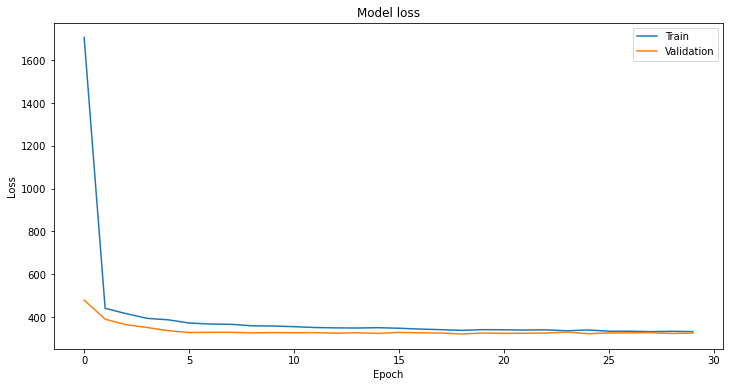

In [34]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [77]:
y_test_dummy['final_result'].value_counts()
test_classified = [0 if y < 50 else 1 for y in y_test_dummy['score'].astype('float32')]
num_zeros = test_classified.count(0)
num_ones = test_classified.count(1)

print(f"Number of 0's: {num_zeros}")
print(f"Number of 1's: {num_ones}")

print('SMOTE')
average_score = y_dummy_smote[y_dummy_smote['final_result'] == 1]['score'].mean()
print(f"Average score where final_result = 1: {average_score}")

average_score = y_dummy_smote[y_dummy_smote['final_result'] == 0]['score'].mean()
print(f"Average score where final_result = 0: {average_score}")

num_entries = len(y_dummy_smote[(y_dummy_smote['final_result'] == 1) & (y_dummy_smote['score'] < 50)])
print(f"Number of entries where final_result = 1 and score < 50: {num_entries}")

num_entries = len(y_dummy_smote[(y_dummy_smote['final_result'] == 0) & (y_dummy_smote['score'] > 50)])
print(f"Number of entries where final_result = 0 and score > 50: {num_entries}")

print('REG')
average_score = y_dummy[y_dummy['final_result'] == 1]['score'].mean()
print(f"Average score where final_result = 1: {average_score}")

average_score = y_dummy[y_dummy['final_result'] == 0]['score'].mean()
print(f"Average score where final_result = 0: {average_score}")

num_entries = len(y_dummy[(y_dummy['final_result'] == 1) & (y_dummy['score'] < 50)])
print(f"Number of entries where final_result = 1 and score < 50: {num_entries}")

num_entries = len(y_dummy[(y_dummy['final_result'] == 0) & (y_dummy['score'] > 50)])
print(f"Number of entries where final_result = 0 and score > 50: {num_entries}")

Number of 0's: 836
Number of 1's: 4712
SMOTE
Average score where final_result = 1: 76.12141706664993
Average score where final_result = 0: 59.681352912263016
Number of entries where final_result = 1 and score < 50: 78
Number of entries where final_result = 0 and score > 50: 9721
REG
Average score where final_result = 1: 76.12141706664993
Average score where final_result = 0: 59.69574552098805
Number of entries where final_result = 1 and score < 50: 78
Number of entries where final_result = 0 and score > 50: 3704


In [97]:
from sklearn.metrics import confusion_matrix, precision_recall_curve
from tensorflow.keras.models import load_model

best_model1 = load_model('model.h5')
best_model2 = load_model('model2.h5')

X_test_dummy_np = X_test_dummy.astype('float32')

preds1 = best_model1.predict(X_test_dummy_np)
print(preds1.shape)
print(y_test_dummy.shape)
precisions, recalls, thresholds = precision_recall_curve(y_test_dummy['final_result'], preds1)
best_threshold = thresholds[np.argmax(precisions + recalls)]

print('best threshold', best_threshold)

predictions_classified1 = [1 if y >= best_threshold else 0 for y in preds1.flatten()]
print(len(predictions_classified))

# y_test_dummy_binary = [1 if y >= 60 else 0 for y in y_test_dummy['score']]
# predictions_classified1 = [1 if y >= 60 else 0 for y in preds1]

acc = accuracy_score(y_test_dummy['final_result'], predictions_classified)
print("acc1", acc)
cm = confusion_matrix(y_test_dummy['final_result'], predictions_classified)

print("Confusion Matrix1:")
print(cm)
positive_preds = np.array(predictions_classified1) == 1

preds2 = best_model2.predict(X_test_dummy_np[positive_preds])
# preds2 = best_model2.predict(X_test_dummy_np)
average_preds = (preds1[positive_preds]*0.5) + (preds2*0.5)



final_preds = np.array(preds1.copy())
final_preds[positive_preds] = average_preds
# final_preds = np.array(preds.copy())

precisions, recalls, thresholds = precision_recall_curve(y_test_dummy_binary, final_preds)
best_threshold = thresholds[np.argmax(precisions + recalls)]

print('best threshold', best_threshold)
final_preds_classified = [1 if y >= best_threshold else 0 for y in final_preds.flatten()]






acc = accuracy_score(y_test_dummy_binary, final_preds_classified)
print("Accuracy", acc)


cm = confusion_matrix(y_test_dummy_binary, final_preds_classified)

print("Confusion Matrix:")
print(cm)


(5548, 1)
(5548, 2)
best threshold 0.36165768
22188


ValueError: Found input variables with inconsistent numbers of samples: [5548, 22188]

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [ ]:
#DO NOT RUN, TAKES FOREVER, OPTIMAL PARAMS PRINTED BELOW

from skopt import BayesSearchCV #pip install scikit-optimize

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from joblib import parallel_backend

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

def create_model(neurons, dropout_rate, num_layers, learning_rate):
    input_layer = Input(shape=(X_train_dummy.shape[1],))

    dense = Dense(neurons, kernel_initializer=tf.keras.initializers.HeNormal())(input_layer)
    dense = BatchNormalization()(dense)
    dense = tf.keras.activations.relu(dense)
    dense = Dropout(dropout_rate)(dense)
    
    for i in range(num_layers - 1):
        dense = Dense(neurons, kernel_initializer=tf.keras.initializers.HeNormal())(dense)
        dense = BatchNormalization()(dense)
        dense = tf.keras.activations.relu(dense)
        dense = Dropout(dropout_rate)(dense)

    output = Dense(1, activation='sigmoid')(dense)
    
    model = tf.keras.models.Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

wrapped_create_model = KerasClassifier(build_fn=create_model, verbose=1, epochs=25)

param_space = {
    'neurons': (8, 512),
    'dropout_rate': (0.1, 0.5),
    'num_layers': (1, 5),
    'learning_rate': (0.0001, 0.1)
}

opt = BayesSearchCV(
    wrapped_create_model,
    param_space,
    n_iter=50,
    cv=3,
    n_jobs=1,
    verbose=1
)

opt.fit(X_train_dummy, y_train_dummy)


In [ ]:
best_params = opt.best_params_
print(best_params)

In [ ]:
optimal_parameters = opt.best_params_

optimal_model = create_model(
    neurons=optimal_parameters['neurons'],
    dropout_rate=optimal_parameters['dropout_rate'],
    num_layers=optimal_parameters['num_layers'],
    learning_rate=optimal_parameters['learning_rate']
)

history = optimal_model.fit(X_train_dummy, y_train_dummy, epochs=30, batch_size=32, validation_split=0.2)

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
score = optimal_model.evaluate(X_test_dummy, y_test_dummy)
print("Accuracy (tuned model):", score[1])